In [147]:
import os
import re
import gc
import random
from copy import deepcopy

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from nltk.stem.wordnet import WordNetLemmatizer
from MulticoreTSNE import MulticoreTSNE as TSNE

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/vagrant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
stop_symbols = ['-', '_', '\\', '(', ')', '/', '|', '<', '>']

def clear_text(text):
    text = text.lstrip('\n').rstrip('\n')
    text = text.replace('\n', ' ').replace('\t', ' ')    
    
    clear_text = ''
    for c in text:
        if c not in stop_symbols and not (c == ' ' and clear_text.endswith(' ')):
            clear_text += c
    return clear_text

def split_documents(raw_document, regexp):
    documents = regexp.findall(raw_document)
    return [clear_text(doc) for doc in documents]

In [4]:
files = [os.path.join('newsgroups', file) for file in os.listdir('newsgroups') if file != 'list.csv']

documents = []
for file_name in files:
    with open(file_name, 'r', errors='replace') as file:
        raw_document = file.read()
        documents.append(raw_document)

In [5]:
print(files)

['newsgroups/alt.atheism.txt', 'newsgroups/comp.graphics.txt', 'newsgroups/comp.os.ms-windows.misc.txt', 'newsgroups/comp.sys.ibm.pc.hardware.txt', 'newsgroups/comp.sys.mac.hardware.txt', 'newsgroups/comp.windows.x.txt', 'newsgroups/misc.forsale.txt', 'newsgroups/rec.autos.txt', 'newsgroups/rec.motorcycles.txt', 'newsgroups/rec.sport.baseball.txt', 'newsgroups/rec.sport.hockey.txt', 'newsgroups/sci.crypt.txt', 'newsgroups/sci.electronics.txt', 'newsgroups/sci.med.txt', 'newsgroups/sci.space.txt', 'newsgroups/soc.religion.christian.txt', 'newsgroups/talk.politics.guns.txt', 'newsgroups/talk.politics.mideast.txt', 'newsgroups/talk.politics.misc.txt', 'newsgroups/talk.religion.misc.txt']


In [6]:
usual_regexp = re.compile('Newsgroup: [A-Za-z\.-]+\ndocument_id: \d+\n(.+?)(?=Newsgroup)', re.DOTALL)

In [212]:
all_documents = pd.DataFrame(columns=['text', 'group'])

for document, file_name in zip(documents, files):
    new_documents = pd.DataFrame({
        'text': split_documents(document, usual_regexp),
        'group': '.'.join(file_name.split('/')[-1].split('.')[:-1])
    })
    all_documents = pd.concat([all_documents, new_documents])

all_documents.to_csv('all_documents.csv', header=True, index=False)

In [24]:
all_documents = pd.read_csv('all_documents.csv', header=0)
all_documents.head()

,group,text
0,alt.atheism,From: mathew mathew@mantis.co.uk Subject: Alt....
1,alt.atheism,From: mathew mathew@mantis.co.uk Subject: Alt....
2,alt.atheism,From: I3150101@dbstu1.rz.tubs.de Benedikt Rose...
3,alt.atheism,From: mathew mathew@mantis.co.uk Subject: Re: ...
4,alt.atheism,From: strom@Watson.Ibm.Com Rob Strom Subject: ...


# EDA

In [79]:
all_documents['len'] = all_documents['text'].apply(len)
all_documents.groupby('group').agg({'len': ['mean', 'std', 'min', 'max', 'size']})

len                             
                                 mean          std min    max size
group                                                             
alt.atheism               1938.569462  2973.460082  34  48077  799
comp.graphics             1469.293936  4985.684617  47  56544  973
comp.os.ms-windows.misc   1949.706599  6627.368833  52  53775  985
comp.sys.ibm.pc.hardware  1037.541752  1239.083123  73  23943  982
comp.sys.mac.hardware      953.004162  1537.991241  61  43988  961
comp.windows.x            1639.113265  5011.050833  52  58257  980
misc.forsale               798.379630   949.283176  50  13633  972
rec.autos                 1179.825253  1314.745039  79  25652  990
rec.motorcycles           1090.711268  1088.199574  70  26553  994
rec.sport.baseball        1254.899396  1234.214935  83  14070  994
rec.sport.hockey          1505.597598  2584.082032  59  65227  999
sci.crypt                 1869.318870  3225.031957  99  54301  991
sci.electronics           1074.940877   847.704998  61  10466  981
sci.med                   1734.116162  3133.175440  67  33654  990
sci.space                 1673.637285  3080.002709  59  55445  987
soc.religion.christian    2185.789368  2445.952958  63  30561  997
talk.politics.guns        1871.227473  2118.743875  80  28895  910
talk.politics.mideast     2911.843617  4749.098551  88  60838  940
talk.politics.misc        2485.628387  4452.854375  93  47752  775
talk.religion.misc        2007.918790  2843.564210  65  46330  628

In [15]:
def tokenize(text):
    text = text.lower()
    regexp = re.compile('[a-z\']+')
    word_list = regexp.findall(text)
    word_list = [word for word in word_list if len(word) >= 2]
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in word_list]

def get_colors(num_colors):
    cm = plt.get_cmap('tab20')
    return [cm(i / num_colors) for i in range(1, num_colors + 1)]
    
def plot_color_dots(tsne_result, labels):
    unique_labels = labels.unique()
    colors = get_colors(len(unique_labels))
    color_map = dict(zip(unique_labels, colors))
    color_map = labels.map(color_map).values
    
    plt.figure(figsize=(15, 10))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=color_map)

## TF-IDF + SVD + T-SNE visualization

In [16]:
tf_idf = TfidfVectorizer(stop_words='english', max_features=1000, tokenizer=tokenize, max_df=0.5)
tf_idf_texts = tf_idf.fit_transform(all_documents['text'])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [18]:
svd = TruncatedSVD(n_iter=10, n_components=100)
svd_texts = svd.fit_transform(tf_idf_texts)

In [19]:
tsne = TSNE(n_jobs=2)
result = tsne.fit_transform(svd_texts)

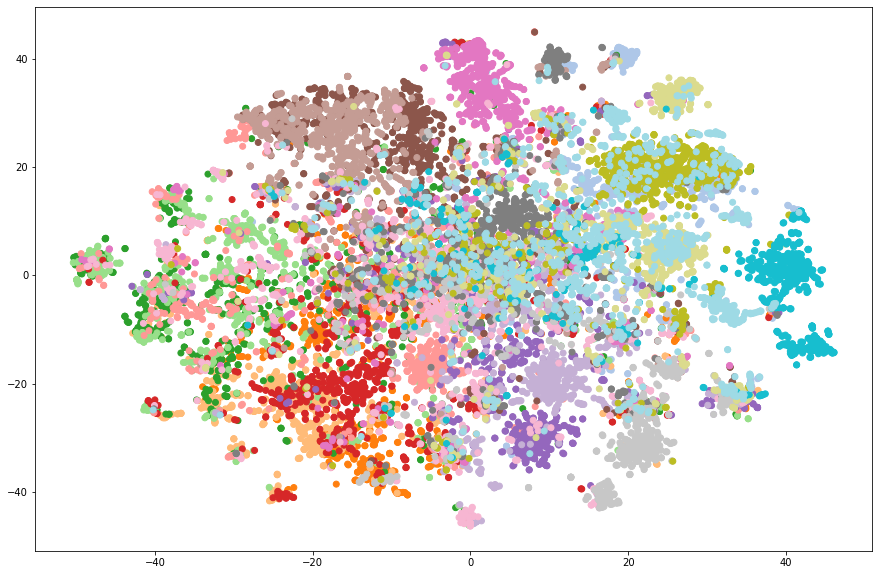

In [21]:
plot_color_dots(result, all_documents['group'])

## Word2Vec + T-SNE visualisation

In [26]:
tokenized_texts = all_documents['text'].apply(tokenize)

In [80]:
word2vec = Word2Vec(tokenized_texts, size=100, window=30, workers=2)

In [153]:
def wv_doc_2_vec(list_of_words, word2vec):
    result = deepcopy(word2vec.wv[list_of_words[0]])
    
    for word in list_of_words[1:]:
        try:
            result += word2vec.wv[word]
        except KeyError:
            pass
    return result / len(list_of_words)


def distance(v1, v2):
    return ((v1 - v2) ** 2).sum() ** 0.5

In [114]:
doc_vectors = tokenized_texts.apply(lambda text: wv_doc_2_vec(text, word2vec))

In [115]:
doc_vectors = np.array([list(item) for item in doc_vectors])

In [126]:
tsne = TSNE(n_jobs=2)
result = tsne.fit_transform(doc_vectors)

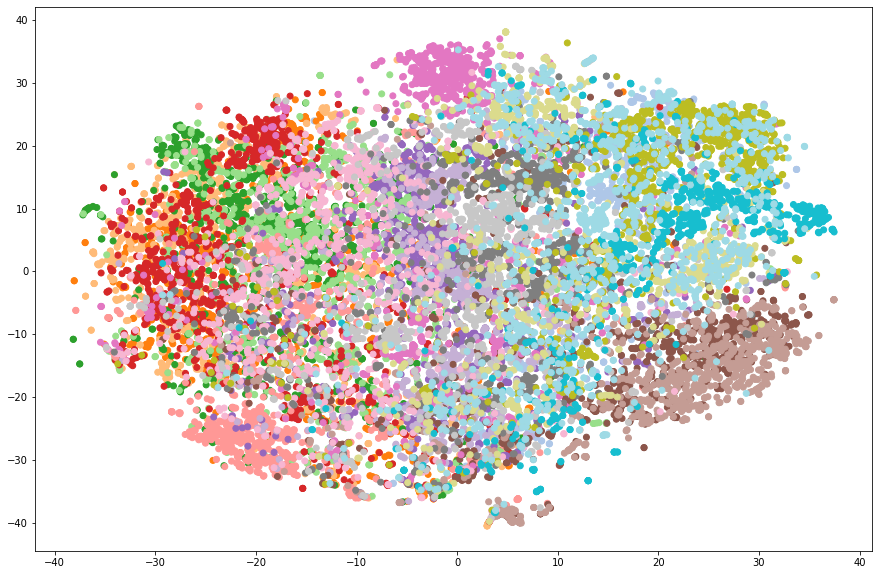

In [127]:
plot_color_dots(result, all_documents['group'])

## Doc2Vec + T-SNE

In [151]:
tagged_texts = [TaggedDocument(text, [i]) for i, text in enumerate(tokenized_texts)]

In [227]:
doc2vec = Doc2Vec(tagged_texts, dm=0, vector_size=100, window=30, workers=2, epochs=20)

In [228]:
doc_vectors = [doc2vec.docvecs[i] for i in range(len(tokenized_texts))]
doc_vectors = np.array([list(item) for item in doc_vectors])

In [229]:
tsne = TSNE(n_jobs=2)
result = tsne.fit_transform(doc_vectors)

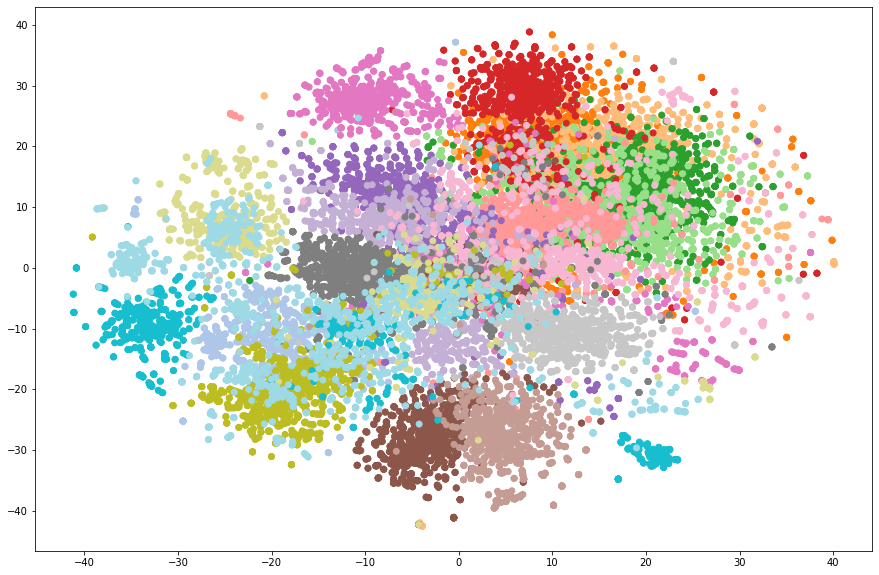

In [230]:
plot_color_dots(result, all_documents['group'])